In [1]:
import sys
import os
import glob
from datetime import datetime
import re

import boto3
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from xarray import open_mfdataset
from netCDF4 import MFDataset, num2date
from matplotlib import image

from cloudflow.services.S3Storage import S3Storage
from cloudflow.job.Plotting import Plotting
from cloudflow.utils import romsUtil as utils

DEBUG = True

In [2]:
def roms_nosofs(COMDIR: str, OFS: str, HH: str):
    '''Load ROMS NOSOFS dataset'''

    filespec = f'{COMDIR}/nos.{OFS}.fields.f*.t{HH}z.nc'
    print(f'filespec is: {filespec}')
    return open_mfdataset(filespec, decode_times=False, combine='by_coords')

In [3]:
def dsofs_curr_fcst(COMROT: str='/com/nos'):
    """ Load the currently run OFS forecast on COMROT 
    This is almost the same as dosfs_newest, but will work better
    when running when injected in a workflow.
    It depends on a file being present in COMROT 'current.fcst'
    """
    
    cur_file = f'{COMROT}/current.fcst'
#     cur_file = f'{COMROT}/testing.fcst'
    
    with open(cur_file) as cf:
        fcst = cf.read().rstrip(' \n')
    
    print('fcst: ', fcst)
    
    COMDIR = f'{COMROT}/{fcst}'
    print('COMDIR: ', COMDIR)

    OFS = fcst.split('.')[0]
    fcstdate = fcst.split('.')[-1]
    HH = fcstdate[8:10]
    
    if DEBUG: # Only grab first 0-9 hours. Faster!
        filespec = f'{COMDIR}/nos.{OFS}.fields.f00*.t{HH}z.nc'
    else: # Grab all hours
        filespec = f'{COMDIR}/nos.{OFS}.fields.f*.t{HH}z.nc'
        
    print(f'filespec is: {filespec}')
    if OFS in utils.roms_models:
        return open_mfdataset(filespec, decode_times=False, combine='by_coords')
    elif OFS in utils.fvcom_models:
        return MFDataset(filespec)
    else:
        print(f"ERROR: model not recognized: {OFS}")
        return None

In [4]:
 #ds_ofs = dsofs_latest()
ds_ofs = dsofs_curr_fcst()

fcst:  cbofs.2020082500
COMDIR:  /com/nos/cbofs.2020082500
filespec is: /com/nos/cbofs.2020082500/nos.cbofs.fields.f00*.t00z.nc


In [17]:
def plot_rho(ds, variable, s3upload=False) -> str:
    
    sample_time = 5
    OFS = ds_ofs.file.split('.')[1]
    
    if variable == 'zeta':
        da = ds[variable].isel(ocean_time=sample_time)
        cmap = cmocean.cm.phase
    if variable == 'temp':
        da = ds[variable].isel(ocean_time=sample_time, s_rho=0)
        cmap = cmocean.cm.thermal
    if variable == 'salt':
        da = ds[variable].isel(ocean_time=sample_time, s_rho=0)
        cmap = cmocean.cm.haline
    if variable == 'oxygen':
        da = ds[variable].isel(ocean_time=sample_time, s_rho=0)
        cmap = cmocean.cm.oxy
    if variable == 'Pair':
        da = ds[variable].isel(ocean_time=sample_time)
        cmap = cmocean.cm.diff
      

    # fig = plt.figure(figsize=(12,5))
    fig = plt.figure()
    # fig = plt.figure(figsize=(12,8))
    print(f'figsize={fig.get_size_inches()}')
    
    ax = fig.add_axes([0, 0.15, 1, 1], projection=ccrs.PlateCarree())
    im = ax.contourf(
        da.lon_rho, da.lat_rho, da.values,
        transform=ccrs.PlateCarree(),
        cmap=cmap
    )
    
    coast_10m = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m',
        edgecolor='k', facecolor='0.8'
    )
    ax.add_feature(coast_10m);
    
    init = ds.ocean_time.isel(ocean_time=0)
    init_str = f"INIT: {num2date(init, init.units)}"
    valid = da.ocean_time
    valid_str = f"VALID: {num2date(valid, valid.units)}"
    
    datestrfmt = '%b %d, %Y %H:%M %Z' #'%Y-%m-%d %H:%M:%S'
    now_str = f"Image generated:\n{datetime.now().strftime(datestrfmt)}"
    
    title = ds.title
    ax.set_title(f'{title}\n{init_str}\n{valid_str}')
    
    long_name = da.attrs['long_name']
    cbar = fig.colorbar(im, ax=ax)
    if variable != 'salt':
        units = da.units
        cbar.set_label(f'{long_name} ({units})')
    else:
        cbar.set_label(f'{long_name}')

    img = image.imread('docs/rps_small.png')
    logo_axis = fig.add_axes([0.265, 0.0, 0.2, 0.1])
    logo_axis.imshow(img, interpolation='hanning')
    logo_axis.axis('off')
    
    datestrfmt = '%b %d, %Y %H:%M %Z' # https://docs.python.org/3/library/datetime.html#aware-and-naive-objects
    now_str = f"Image generated:\n{datetime.now().strftime(datestrfmt)}"
    fig.text(0.55, 0.025, f'{now_str}')
    
    plt.savefig('docs/roms_test.png', bbox_inches='tight')

figsize=[6. 4.]


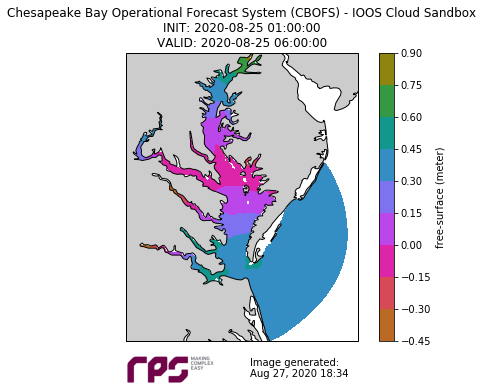

In [18]:
rho_vars = ['temp', 'zeta', 'salt']
var = np.random.choice(rho_vars)

plot_rho(ds_ofs, var)